# 1.KNN estimator with a kernel funtion (20 pts)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2023)

## 1.1Generate data points

In [2]:
x_trian = np.concatenate([np.random.normal(-20, 10, 20), np.random.normal(10, 5, 10)])
x_trian =x_trian.reshape((-1,1))
x_test = np.linspace(np.min(x_trian),np.max(x_trian),100)
x_test = x_test.reshape((-1,1))


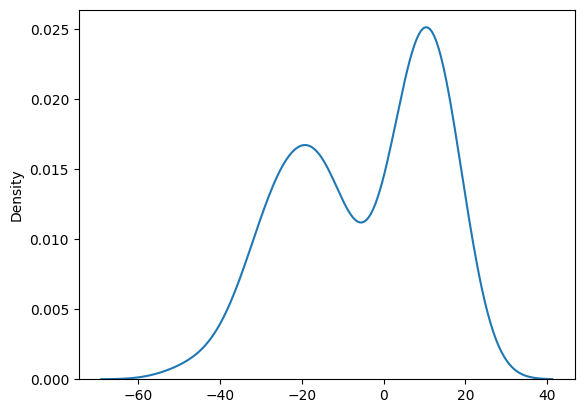

In [3]:
#  sampling  many dpoins for approximating the true distribution
# this is a multimodal density
sns.kdeplot(np.concatenate([np.random.normal(-20, 10, 100), np.random.normal(10, 5, 100)]))
plt.show()

## 1.2 Complete the code and draw the pictures
Completing KNN estimator wtih a kernel funtion. 
The kernel funtion is a Gaussian kernel, defined by $$K(u)=\frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{\tau}),$$
where $\tau$ is the length-scale. 

**Task:** You should complete the code for the KNN estimator with a Gaussian kernel function and plot the estimated density with three sets of parameters, as shown below
- k=3,$\tau=2$
- k=3,$\tau=0.2$
- k=5,$\tau=2$

**Hint:** We have already generated a set of test points and saved them in the variable x_test. Your task is to plot the estimated density function $\hat{p}(x)$ based on these points. The code framework has been provided, and you can either write it from scratch or fill in the missing parts in the framework.

In [4]:
##########################
#Define your KNN estimator 
#########################
class KNNKernelEstimator:
    def __init__(self, k=5, length_scale=2):
        self.k = k
        self.length_scale  =length_scale

    def fit(self, X):
        self.X = X
        self.N = X.shape[0]

    def predict(self, X_test):
        testNum = X_test.shape[0]
        y_pred = np.zeros(len(X_test))

        for i in range(testNum):
            x_test = X_test[i]
            distances = np.linalg.norm(self.X - x_test, axis=1)
            indices = np.argsort(distances)[:self.k]
            indice_k = indices[-1]
            distances_k = distances[indice_k]
            u_value = distances /distances_k
            weights = self.kernelize(u_value)
            y_pred[i] = np.sum(weights)/(self.N*distances_k)

        return y_pred

    def kernelize(self, distances):
        return 1/np.sqrt(2*np.pi)*np.exp(-distances**2 /self.length_scale)


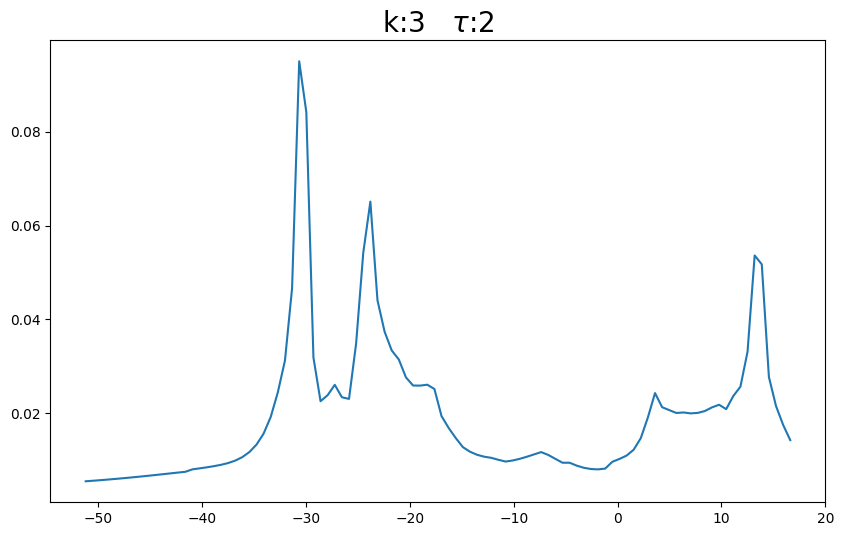

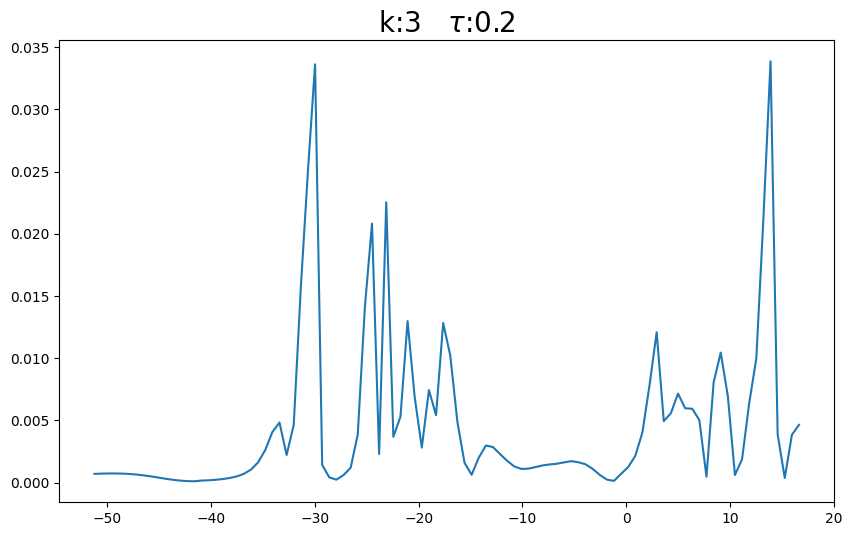

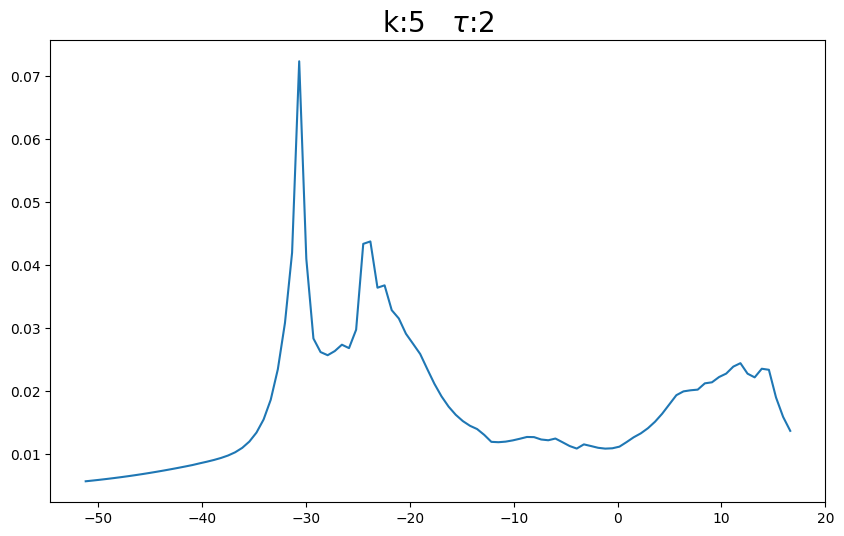

In [5]:
k=3
tau=2
kke = KNNKernelEstimator(k,tau)
kke.fit(x_trian)
predict_x = kke.predict(x_test)
plt.figure(figsize=(10,6))
plt.plot(x_test,predict_x)
plt.title("k:"+str(k)+r"   $\tau$:"+str(tau),fontsize=20)
plt.show()

k=3
tau=0.2
kke = KNNKernelEstimator(k,tau)
kke.fit(x_trian)
predict_x = kke.predict(x_test)
plt.figure(figsize=(10,6))
plt.plot(x_test,predict_x)
plt.title("k:"+str(k)+r"   $\tau$:"+str(tau),fontsize=20)
plt.show()

k=5
tau=2
kke = KNNKernelEstimator(k,tau)
kke.fit(x_trian)
predict_x = kke.predict(x_test)
plt.figure(figsize=(10,6))
plt.plot(x_test,predict_x)
plt.title("k:"+str(k)+r"   $\tau$:"+str(tau),fontsize=20)
plt.show()

# 2.Deep Learning for classification (30 pts)

For this task, you are required to design and train a deep neural network to perform a classification task on a provided dataset. The dataset can be found at the following link: http://pan.shanghaitech.edu.cn/cloudservice/outerLink/decode?c3Vnb24xNjgyNzcwODk4OTU5c3Vnb24=

The dataset consists of a training set, validation set, and test set. The training set should be used to train your model, the validation set should be used to choose the best model, and the test set should be used to evaluate the performance of your model.

**Your goal is to achieve at least 70% accuracy on the test set using your trained model. One point is deducted for every point the accuracy decreases**， such as 66.2% will lose 4 points.

If your computer does not have the necessary resources to train a deep neural network, you may use the computing resources of a school computing cluster, Kaggle, or Google Colab.

Hint:The use of pre-training models is prohibited (direct zero points) and custom neural networks are encouraged.



In [1]:
import os
import numpy as np
# !pip install opencv-python  # the command for installing opencv,i.e, cv2
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import warnings
import  torch.nn.functional as F

warnings.filterwarnings("ignore")


In [2]:
# load the data set
def readfile(path, label):
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [3]:
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
test_x, test_y = readfile(os.path.join(workspace_dir, "testing"), True)
print("Size of test data = {}".format(len(test_x)))

Reading data
Size of training data = 9318
Size of test data = 3430


In [5]:

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), #  随机将图片翻转
    transforms.RandomRotation(30), #  随机旋转图片
    transforms.ToTensor(), # 將图片转成 Tensor，並把数值normalize到[0,1](data normalization)
])
#testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [6]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = ImgDataset(test_x, test_y, test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 2.2 Construct deep learning model

In [7]:
################################
#Define your nerual network
##################################
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn = nn.Sequential(
            # VGG 16
            nn.Conv2d(3, 64, 3, 1, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # 64 64

            nn.Conv2d(64, 128, 3, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # 32 * 32

            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # 16 * 16

            nn.Conv2d(256, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # 8 * 8
            
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),    # 4 * 4 
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 11)
        )


    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

     

## 2.3 trianing your model
There are some tips which I hope can help you complete the task:
- If the loss function goes down too slowly, you can make the step size larger. This trick is better combined with an adaptive learning rate regulator
- If the model is overfitting, you can add a dropout layer in your model. 
-  [Data augmentation](https://pytorch.org/vision/stable/transforms.html) is also a good way to increase model generalization. We recommend that you do this.


In [12]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)# optimizer 使用 Adam
num_epoch = 100

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_set.__len__(), train_loss/train_set.__len__()))

[001/100] 16.25 sec(s) Train Acc: 0.165593 Loss: 0.017886
[002/100] 16.26 sec(s) Train Acc: 0.259605 Loss: 0.016402
[003/100] 16.27 sec(s) Train Acc: 0.327538 Loss: 0.015016
[004/100] 16.47 sec(s) Train Acc: 0.379588 Loss: 0.014046
[005/100] 16.33 sec(s) Train Acc: 0.413286 Loss: 0.013256
[006/100] 16.82 sec(s) Train Acc: 0.453531 Loss: 0.012476
[007/100] 16.49 sec(s) Train Acc: 0.478536 Loss: 0.011883
[008/100] 16.67 sec(s) Train Acc: 0.509444 Loss: 0.011224
[009/100] 16.63 sec(s) Train Acc: 0.539815 Loss: 0.010520
[010/100] 16.62 sec(s) Train Acc: 0.561387 Loss: 0.010040
[011/100] 16.46 sec(s) Train Acc: 0.589182 Loss: 0.009476
[012/100] 16.61 sec(s) Train Acc: 0.608500 Loss: 0.009006
[013/100] 17.10 sec(s) Train Acc: 0.614402 Loss: 0.008900
[014/100] 17.35 sec(s) Train Acc: 0.644774 Loss: 0.008223
[015/100] 16.40 sec(s) Train Acc: 0.652715 Loss: 0.008008
[016/100] 16.37 sec(s) Train Acc: 0.670316 Loss: 0.007622
[017/100] 16.45 sec(s) Train Acc: 0.680296 Loss: 0.007327
[018/100] 16.6

# Test your model
use your trained model to test the test set and print the accuracy.

In [13]:

model.eval()
test_acc = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model(data[0].cuda())
        test_acc +=np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())

test_acc = test_acc/test_set.__len__()
print("Test Acc: "+str(test_acc))

Test Acc: 0.7309037900874635
